In [10]:
from campa.constants import campa_config
from campa_ana.constants import SOURCE_DIR
from campa.data import MPPData
from campa.tl import Experiment, FeatureExtractor
from campa.tl import Cluster
from campa.tl._cluster import add_clustering_to_adata
from campa.pl import annotate_img
from campa.utils import init_logging
import os
import numpy as np
import scanpy as sc
from pathlib import Path
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'
plt.rcParams["font.family"] = "Helvetica"
init_logging()

#campa_config.config_fname = '/home/icb/hannah.spitzer/projects/pelkmans/software_new/campa/config_o.ini'

In [2]:
# NOTE added 0.5h to all times, to reflect time from fixation
def add_perturbation_plot(adata):
    # create perturbation_plot column from perturbation_duration column
    p = np.array(adata.obs['perturbation_duration'])
    p[p == 'AZD4573-120'] = 'AZD4573 (2.5h)'
    p[p == 'AZD4573-30'] = 'AZD4573 (1h)'
    p[p == 'CX5461-120'] = 'CX5461 (2.5h)'
    p[p == 'Meayamycin-720'] = 'Meayamycin (12.5h)'
    p[p == 'TSA-30'] = 'TSA (1h)'
    p[p == 'Triptolide-120'] = 'Triptolide (2.5h)'
    p[np.in1d(p, ['DMSO-120', 'DMSO-720', 'normal'])] = 'unperturbed'
    adata.obs['perturbation_plot'] = p
    adata.obs['perturbation_plot'] = adata.obs['perturbation_plot'].astype('category')

In [3]:
fig_dir = Path(SOURCE_DIR)/'figures'/'fig1'
suppl_dir = Path(SOURCE_DIR)/'figures'/'fig1_suppl'
os.makedirs(str(fig_dir), exist_ok=True)
os.makedirs(str(suppl_dir), exist_ok=True)

In [4]:
# colors for pixel approach and condVAE:
yellow = '#f8ba00'
blue = '#00a2ff'
green = '#96be25'

# wells to select example cells from
data_dirs = {
    'Triptolide (2.5h)': '184A1_triptolide/I10',
    'unperturbed': '184A1_unperturbed/I09',
    'TSA (1h)': '184A1_TSA/I16', 
#    'Meayamycin (12.5h)': '184A1_meayamycin/I12'
}

## Load data

In [51]:
adatas = {}
adatas_sub = {}
extrs = {}

exp_name = 'VAE_all/CondVAE_pert-CC'
cluster_data_dir = os.path.join(exp_name, 'aggregated/sub-0.001')
# load cl
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X='mpp', obsm={'X_latent': 'latent', 'X_umap': 'umap'})
# add clustering and colormap (from cluster_name_annotation.csv) to adata
cl.set_cluster_name('clustering_res0.5') 
add_clustering_to_adata(os.path.join(campa_config.EXPERIMENT_DIR, cluster_data_dir), 'clustering_res0.5', adata, cl.cluster_annotation)
add_clustering_to_adata(os.path.join(campa_config.EXPERIMENT_DIR, cluster_data_dir), 'clustering_res0.5', adata, cl.cluster_annotation, annotation_col='annotation')
add_clustering_to_adata(os.path.join(campa_config.EXPERIMENT_DIR, cluster_data_dir), 'clustering_res0.5', adata, cl.cluster_annotation, annotation_col='annotation_fine')


# create perturbation names to plot
add_perturbation_plot(adata)

# subset of data used in some panels
adata_sub = adata[adata.obs['perturbation_plot'].isin(
    ['Triptolide (2.5h)', 'unperturbed', 'TSA (1h)'])]
adatas['CondVAE'] = adata
adatas_sub['CondVAE'] = adata_sub

# load feature extractor for pie chart
exp = Experiment.from_dir(exp_name)
extrs['CondVAE'] = {data_dir: FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_annotation.h5ad'))   # TODO use features_annotation_fine here
    for data_dir in exp.data_params['data_dirs'][:-1]}


INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'latent', 'umap'].
INFO:MPPData:Loaded data from VAE_all/CondVAE_pert-CC/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'latent', 'umap'].
INFO:Cluster:cannot create annotation without clustering in cluster_mpp
INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'latent', 'clustering_res0.5', 'umap'].
INFO:MPPData:Loaded data from VAE_all/CondVAE_pert-CC/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'latent', 'clustering_res0.5', 'umap'].
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO

In [6]:
exp_name = 'VAE_all/VAE'
cluster_data_dir = os.path.join(exp_name, 'aggregated/sub-0.001')
# load cl
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X='mpp', obsm={'X_latent': 'latent', 'X_umap': 'umap'})
# add clustering and colormap (from cluster_name_annotation.csv) to adata
cl.set_cluster_name('clustering_res0.5') 
add_clustering_to_adata(os.path.join(campa_config.EXPERIMENT_DIR, cluster_data_dir), 'clustering_res0.5', adata, cl.cluster_annotation)

# create perturbation names to plot
add_perturbation_plot(adata)

# subset of data used in some panels
adata_sub = adata[adata.obs['perturbation_plot'].isin(
    ['Triptolide (2.5h)', 'unperturbed', 'TSA (1h)'])]
adatas['VAE'] = adata
adatas_sub['VAE'] = adata_sub

INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'latent', 'umap'].
INFO:MPPData:Loaded data from VAE_all/VAE/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'latent', 'umap'].
INFO:Cluster:cannot create annotation without clustering in cluster_mpp
INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'latent', 'clustering_res0.5', 'umap'].
INFO:MPPData:Loaded data from VAE_all/VAE/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'latent', 'clustering_res0.5', 'umap'].


Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/VAE/aggregated/sub-0.001/clustering_res0.5.npy


In [7]:
exp_name = 'VAE_all/MPPleiden'
cluster_data_dir = os.path.join(exp_name, 'aggregated/sub-0.001')
# load cl
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X='mpp', obsm={'X_umap': 'umap'})
# add clustering and colormap (from cluster_name_annotation.csv) to adata
for res in [0.2, 0.4, 0.6, 0.8, 1.2, 1.6, 2.0]:
    cl.set_cluster_name(f'clustering_res{res:.1f}') 
    add_clustering_to_adata(os.path.join(campa_config.EXPERIMENT_DIR, cluster_data_dir), f'clustering_res{res:.1f}', adata, cl.cluster_annotation)

# create perturbation names to plot
add_perturbation_plot(adata)

# subset of data used in some panels
adata_sub = adata[adata.obs['perturbation_plot'].isin(
    ['Triptolide (2.5h)', 'unperturbed', 'TSA (1h)'])]
adatas['MPPleiden'] = adata
adatas_sub['MPPleiden'] = adata_sub


INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'umap'].
INFO:MPPData:Loaded data from VAE_all/MPPleiden/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'umap'].
INFO:Cluster:cannot create annotation without clustering in cluster_mpp
INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'clustering_res0.2', 'umap'].
INFO:MPPData:Loaded data from VAE_all/MPPleiden/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'clustering_res0.2', 'umap'].
INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['

Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/MPPleiden/aggregated/sub-0.001/clustering_res0.2.npy
Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/MPPleiden/aggregated/sub-0.001/clustering_res0.4.npy


INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'clustering_res0.6', 'umap'].
INFO:MPPData:Loaded data from VAE_all/MPPleiden/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'clustering_res0.6', 'umap'].
INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'clustering_res0.8', 'umap'].
INFO:MPPData:Loaded data from VAE_all/MPPleiden/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'clustering_res0.8', 'umap'].


Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/MPPleiden/aggregated/sub-0.001/clustering_res0.6.npy
Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/MPPleiden/aggregated/sub-0.001/clustering_res0.8.npy


INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'clustering_res1.2', 'umap'].
INFO:MPPData:Loaded data from VAE_all/MPPleiden/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'clustering_res1.2', 'umap'].
INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'clustering_res1.6', 'umap'].
INFO:MPPData:Loaded data from VAE_all/MPPleiden/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'clustering_res1.6', 'umap'].


Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/MPPleiden/aggregated/sub-0.001/clustering_res1.2.npy
Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/MPPleiden/aggregated/sub-0.001/clustering_res1.6.npy


INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'clustering_res2.0', 'umap'].
INFO:MPPData:Loaded data from VAE_all/MPPleiden/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp', 'clustering_res2.0', 'umap'].


Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/MPPleiden/aggregated/sub-0.001/clustering_res2.0.npy


In [8]:
# example data
example_mpp_data = {'CondVAE':{}, 'MPPleiden': {}, 'VAE':{}}

for name, data_dir in data_dirs.items():
    print(data_dir)
    example_mpp_data['CondVAE'][name] = MPPData.from_data_dir(data_dir, base_dir=os.path.join(campa_config.EXPERIMENT_DIR, 'VAE_all/CondVAE_pert-CC/aggregated/full_data'), 
                                                    keys=['x', 'y', 'obj_ids', 'latent'], optional_keys=[], data_config="NascentRNA")

for name, data_dir in data_dirs.items():
    print(data_dir)
    example_mpp_data['MPPleiden'][name] = MPPData.from_data_dir(data_dir, base_dir=os.path.join(campa_config.EXPERIMENT_DIR, 'VAE_all/MPPleiden/aggregated/full_data'), 
                                                    keys=['x', 'y', 'obj_ids', 'mpp'], optional_keys=[], data_config="NascentRNA")
    
for name, data_dir in data_dirs.items():
    print(data_dir)
    example_mpp_data['VAE'][name] = MPPData.from_data_dir(data_dir, base_dir=os.path.join(campa_config.EXPERIMENT_DIR, 'VAE_all/VAE/aggregated/full_data'), 
                                                    keys=['x', 'y', 'obj_ids', 'latent'], optional_keys=[], data_config="NascentRNA")




184A1_triptolide/I10


INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (10609863 mpps with shape (1, 1, 35) from 842 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Loaded data from 184A1_triptolide/I10.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (5998677 mpps with shape (1, 1, 34) from 506 objects). Data keys: ['latent', 'obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Before subsetting: 842 objects
INFO:MPPData:Subsetting to 506 objects
INFO:MPPData:Updated data to keys ['obj_ids', 'x', 'y', 'mpp', 'latent']
INFO:MPPData:Loaded data from 184A1_triptolide/I10, with base data from 184A1_triptolide/I10


184A1_unperturbed/I09


INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I09.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (7218204 mpps with shape (1, 1, 34) from 557 objects). Data keys: ['latent', 'obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to 557 objects
INFO:MPPData:Updated data to keys ['obj_ids', 'x', 'y', 'mpp', 'latent']
INFO:MPPData:Loaded data from 184A1_unperturbed/I09, with base data from 184A1_unperturbed/I09


184A1_TSA/I16


INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (13348206 mpps with shape (1, 1, 35) from 994 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Loaded data from 184A1_TSA/I16.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (7712953 mpps with shape (1, 1, 34) from 617 objects). Data keys: ['latent', 'obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Before subsetting: 994 objects
INFO:MPPData:Subsetting to 617 objects
INFO:MPPData:Updated data to keys ['obj_ids', 'x', 'y', 'mpp', 'latent']
INFO:MPPData:Loaded data from 184A1_TSA/I16, with base data from 184A1_TSA/I16


184A1_triptolide/I10


INFO:MPPData:Created new: MPPData for NascentRNA (10609863 mpps with shape (1, 1, 35) from 842 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Loaded data from 184A1_triptolide/I10.
INFO:MPPData:Created new: MPPData for NascentRNA (5998677 mpps with shape (1, 1, 34) from 506 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Before subsetting: 842 objects
INFO:MPPData:Subsetting to 506 objects
INFO:MPPData:Updated data to keys ['obj_ids', 'x', 'y', 'mpp']
INFO:MPPData:Loaded data from 184A1_triptolide/I10, with base data from 184A1_triptolide/I10


184A1_unperturbed/I09


INFO:MPPData:Created new: MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I09.
INFO:MPPData:Created new: MPPData for NascentRNA (7218204 mpps with shape (1, 1, 34) from 557 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to 557 objects
INFO:MPPData:Updated data to keys ['obj_ids', 'x', 'y', 'mpp']
INFO:MPPData:Loaded data from 184A1_unperturbed/I09, with base data from 184A1_unperturbed/I09


184A1_TSA/I16


INFO:MPPData:Created new: MPPData for NascentRNA (13348206 mpps with shape (1, 1, 35) from 994 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Loaded data from 184A1_TSA/I16.
INFO:MPPData:Created new: MPPData for NascentRNA (7712953 mpps with shape (1, 1, 34) from 617 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Before subsetting: 994 objects
INFO:MPPData:Subsetting to 617 objects
INFO:MPPData:Updated data to keys ['obj_ids', 'x', 'y', 'mpp']
INFO:MPPData:Loaded data from 184A1_TSA/I16, with base data from 184A1_TSA/I16


184A1_triptolide/I10


INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (10609863 mpps with shape (1, 1, 35) from 842 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Loaded data from 184A1_triptolide/I10.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (5998677 mpps with shape (1, 1, 35) from 506 objects). Data keys: ['latent', 'obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Before subsetting: 842 objects
INFO:MPPData:Subsetting to 506 objects
INFO:MPPData:Updated data to keys ['obj_ids', 'x', 'y', 'mpp', 'latent']
INFO:MPPData:Loaded data from 184A1_triptolide/I10, with base data from 184A1_triptolide/I10


184A1_unperturbed/I09


INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I09.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (7218204 mpps with shape (1, 1, 35) from 557 objects). Data keys: ['latent', 'obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to 557 objects
INFO:MPPData:Updated data to keys ['obj_ids', 'x', 'y', 'mpp', 'latent']
INFO:MPPData:Loaded data from 184A1_unperturbed/I09, with base data from 184A1_unperturbed/I09


184A1_TSA/I16


INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (13348206 mpps with shape (1, 1, 35) from 994 objects). Data keys: ['obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Loaded data from 184A1_TSA/I16.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (7712953 mpps with shape (1, 1, 35) from 617 objects). Data keys: ['latent', 'obj_ids', 'x', 'y', 'mpp'].
INFO:MPPData:Before subsetting: 994 objects
INFO:MPPData:Subsetting to 617 objects
INFO:MPPData:Updated data to keys ['obj_ids', 'x', 'y', 'mpp', 'latent']
INFO:MPPData:Loaded data from 184A1_TSA/I16, with base data from 184A1_TSA/I16


## Umaps and example cells

In [63]:
sns.set_style('white')
sns.set_context('talk')

perturbation_plot_colors = {
    'unperturbed': "#999999",
#    'Meayamycin (12.5h)':  "#56B4E9",
    'Triptolide (2.5h)': "#008000", #"#E69F00",
    'TSA (1h)': "#00FF00", # "#009E73",
}

### CondVAE

In [57]:
adata = adatas['CondVAE']
adata_sub = adatas_sub['CondVAE']
# add colors
adata_sub.uns['perturbation_plot_colors'] = [perturbation_plot_colors[p] for p in adata_sub.obs['perturbation_plot'].cat.categories]

In [62]:
# ensure rasterization of scatter plots
sc._settings.settings._vector_friendly=True

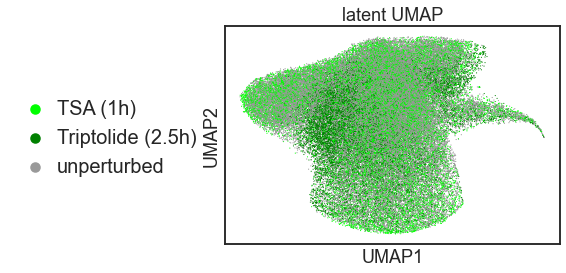

In [77]:
# plot perturbation on subset of data
# ensure that order of points is random
random_indices=np.random.permutation(list(range(adata_sub.shape[0])))
fig, ax = plt.subplots()
sc.pl.umap(adata_sub[random_indices], color='perturbation_plot', size=5, legend_loc='right margin', title='latent UMAP', ax=ax, show=False)
# move legend
plt.legend(bbox_to_anchor=(-0.65, 0.7), loc=2, borderaxespad=0., ncol=1, frameon=False, prop={'size': 20}, handletextpad=0.1)
plt.savefig(fig_dir/'umap_condVAE_perturbation.pdf', bbox_inches='tight', dpi=300)

/home/icb/hannah.spitzer/miniconda3/envs/campa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


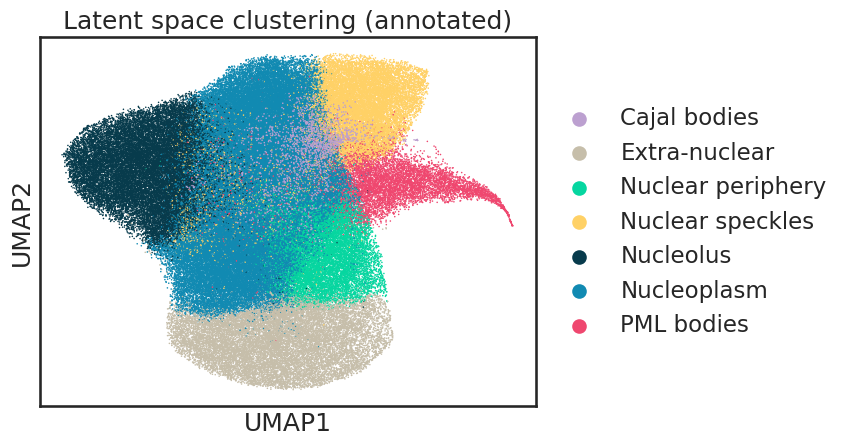

In [12]:
# plot annotated clustering (with cajal bodies on top) on all data
indices = set(range(adata.shape[0]))
cajal_indices = list(np.where(adata.obs['annotation'] == 'Cajal bodies')[0])
reordered_indices = list(indices.difference(cajal_indices)) + cajal_indices
fig, ax = plt.subplots()
sc.pl.umap(adata[reordered_indices], color='annotation', size=5, legend_loc='right margin', title='Latent space clustering (annotated)', ax=ax, show=False)
plt.savefig(fig_dir/'umap_condVAE_annotation_all.png', bbox_inches='tight', dpi=300)

/home/icb/hannah.spitzer/miniconda3/envs/campa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


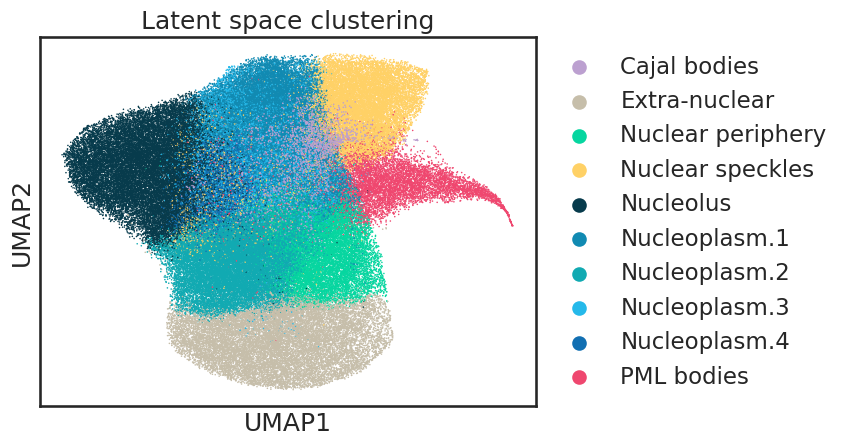

In [13]:
# plot unannotated clustering (with cajal bodies on top) on all data
indices = set(range(adata.shape[0]))
cajal_indices = list(np.where(adata.obs['annotation_fine'] == 'Cajal bodies')[0])
reordered_indices = list(indices.difference(cajal_indices)) + cajal_indices
fig, ax = plt.subplots()
sc.pl.umap(adata[reordered_indices], color='annotation_fine', size=5, legend_loc='right margin', title='Latent space clustering', ax=ax, show=False)
plt.savefig(fig_dir/'umap_condVAE_annotation_fine_all.png', bbox_inches='tight', dpi=300)

#### example cells - annotated

In [12]:
cluster_data_dir = os.path.join('VAE_all/CondVAE_pert-CC', 'aggregated/sub-0.001')
num_objs = 5
cluster_name = 'clustering_res0.5'

example_cells = {}
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
cl.set_cluster_name(cluster_name) 
for name, mpp_data in example_mpp_data['CondVAE'].items():
    # choose num_objs cells
    rng = np.random.default_rng(seed=40)
    obj_ids = rng.choice(mpp_data.unique_obj_ids, num_objs, replace=False)
    print(name, obj_ids)    
    sub_mpp_data = cl.project_clustering(mpp_data.subset(obj_ids=obj_ids, copy=True))
    example_cells[name] = sub_mpp_data.get_object_imgs(data=cluster_name, annotation_kwargs={'color':True, 'annotation': cl.cluster_annotation, 'to_col': 'annotation'}, img_size=160)


INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent', 'umap'].
INFO:MPPData:Loaded data from VAE_all/CondVAE_pert-CC/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent', 'umap'].
INFO:Cluster:cannot create annotation without clustering in cluster_mpp
INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent', 'clustering_res0.5', 'umap'].
INFO:MPPData:Loaded data from VAE_all/CondVAE_pert-CC/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent', 'clustering_res0.5', 'umap'].
INFO:MPPData:Before subsetting: 506 objects
INFO:MPPData:Subsettin

Triptolide (2.5h) [328097 194924 328071 296478 273257]


INFO:MPPData:Created new: MPPData for NascentRNA (52084 mpps with shape (1, 1, 35) from 5 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent'].
INFO:Cluster:Projecting clustering to 52084 samples
INFO:Cluster:processing chunk 0
INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to 5 objects


unperturbed [347720 199656 345913 306933 280842]


INFO:MPPData:Created new: MPPData for NascentRNA (51592 mpps with shape (1, 1, 35) from 5 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent'].
INFO:Cluster:Projecting clustering to 51592 samples
INFO:Cluster:processing chunk 0
INFO:MPPData:Before subsetting: 617 objects
INFO:MPPData:Subsetting to 5 objects


TSA (1h) [341998 205243 341873 314239 304075]


INFO:MPPData:Created new: MPPData for NascentRNA (64506 mpps with shape (1, 1, 35) from 5 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent'].
INFO:Cluster:Projecting clustering to 64506 samples
INFO:Cluster:processing chunk 0


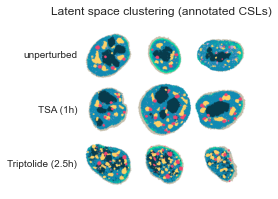

In [14]:
perts = ['unperturbed', 'TSA (1h)', 'Triptolide (2.5h)']
sns.set_context('talk')
with sns.axes_style('white'):
    fig, axes = plt.subplots(3,3, figsize=(3,3))
    for j, col in enumerate(axes.T):
        for i, ax in enumerate(col):
            ax.imshow(example_cells[perts[i]][j])
            ax.set_yticks([])
            ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(perts[i], rotation=0, ha='right', va='center', fontsize=10)
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle('Latent space clustering (annotated CSLs)', size=12)
    sns.despine(left=True, bottom=True)
plt.savefig(fig_dir/'example_cells_CondVAE.pdf', dpi=300, bbox_inches='tight')

/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_51534/2299154082.py:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


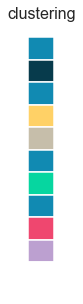

In [13]:
# build cluster colorbar
fig, ax = plt.subplots(1,1, figsize=(0.5,5))
ax.barh(range(11), height=1, width=1, color=cl.cluster_annotation['annotation_colors'])
ax.set_title('clustering', fontdict={'fontsize': 16})
ax.invert_yaxis()
ax.axis('off')
plt.tight_layout()
plt.savefig(fig_dir/'cluster_colorbar_CondVAE.pdf', dpi=100, bbox_inches='tight')

#### example cells - unannotated

In [15]:
cluster_data_dir = os.path.join('VAE_all/CondVAE_pert-CC', 'aggregated/sub-0.001')
num_objs = 5
cluster_name = 'clustering_res0.5'

example_cells = {}
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
cl.set_cluster_name(cluster_name) 
for name, mpp_data in example_mpp_data['CondVAE'].items():
     # choose num_objs cells
     rng = np.random.default_rng(seed=40)
     obj_ids = rng.choice(mpp_data.unique_obj_ids, num_objs, replace=False)
     sub_mpp_data = cl.project_clustering(mpp_data.subset(obj_ids=obj_ids, copy=True))
     example_cells[name] = sub_mpp_data.get_object_imgs(data=cluster_name, annotation_kwargs={'color':True, 'annotation': cl.cluster_annotation, 'to_col': 'annotation_fine'}, img_size=160)



INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent', 'umap'].
INFO:MPPData:Loaded data from VAE_all/CondVAE_pert-CC/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent', 'umap'].
INFO:Cluster:cannot create annotation without clustering in cluster_mpp
INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent', 'clustering_res0.5', 'umap'].
INFO:MPPData:Loaded data from VAE_all/CondVAE_pert-CC/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent', 'clustering_res0.5', 'umap'].
INFO:MPPData:Before subsetting: 506 objects
INFO:MPPData:Subsettin

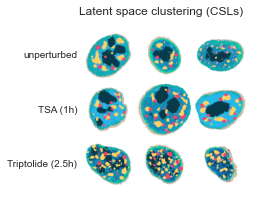

In [16]:
perts = ['unperturbed', 'TSA (1h)', 'Triptolide (2.5h)']
sns.set_context('talk')
with sns.axes_style('white'):
    fig, axes = plt.subplots(3,3, figsize=(3,3))
    for j, col in enumerate(axes.T):
        for i, ax in enumerate(col):
            ax.imshow(example_cells[perts[i]][j])
            ax.set_yticks([])
            ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(perts[i], rotation=0, ha='right', va='center', fontsize=10)
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle('Latent space clustering (CSLs)', size=12)
    sns.despine(left=True, bottom=True)
plt.savefig(fig_dir/'example_cells_CondVAE_unannotated.pdf', dpi=300, bbox_inches='tight')

/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_51534/2171042556.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


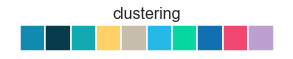

In [17]:
# build cluster colorbar
fig, ax = plt.subplots(1,1, figsize=(5,0.5))
ax.bar(range(10), height=1, width=1, color=cl.cluster_annotation['annotation_fine_colors'])
ax.set_title('clustering', fontdict={'fontsize': 16})
ax.invert_yaxis()
ax.axis('off')
plt.tight_layout()
plt.savefig(fig_dir/'cluster_colorbar_CondVAE_unannotated.pdf', dpi=100, bbox_inches='tight')

#### pie chart
use data from all pixels, not only subset - use extractor for this

In [52]:
for extr in extrs['CondVAE'].values():
    add_perturbation_plot(extr.adata)

# concatenate object stats over all perturbations
object_stats = pd.concat([extr.adata.uns['object_stats'] for extr in extrs['CondVAE'].values()])

# get metadata (perturbation info)
metadata = pd.concat([extr.adata.obs for extr in extrs['CondVAE'].values()])
metadata['mapobject_id'] = metadata['mapobject_id'].astype(int)

object_stats = pd.merge(object_stats, metadata, how='left', left_on='mapobject_id', right_on='mapobject_id')

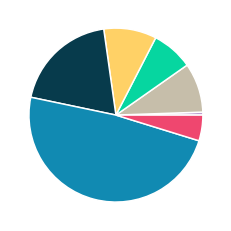

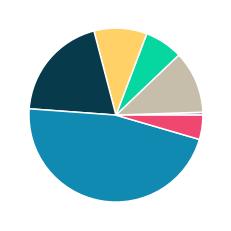

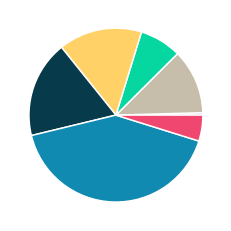

In [64]:
# pie chart - TODO rerun with annotation_fine
cluster_size = {}
for pert, grp in object_stats.groupby('perturbation_plot'):
    cluster_size[pert] = grp.groupby('clustering')['area'].sum()
df = pd.concat(cluster_size, axis=1)
df = df / df.sum(axis=0)

df = pd.merge(df, cl.cluster_annotation, how='left', left_index=True, right_on='annotation')  # TODO use annotation_fine here
# TODO can be removed when using annotation_fine
df = df.drop_duplicates(subset=['AZD4573 (1h)'])

for pert in ['unperturbed', 'TSA (1h)', 'Triptolide (2.5h)']:
    plt.figure()
    _ = plt.pie(df[pert], colors = df['annotation_fine_colors'])
    plt.savefig(fig_dir/f'cluster_pie_chart_CondVAE_{pert}.pdf', dpi=300, bbox_inches='tight')

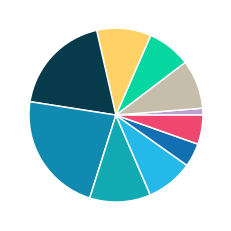

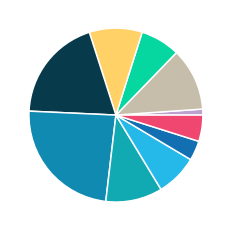

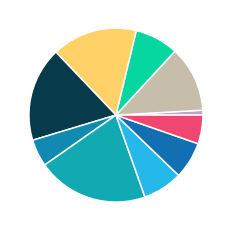

In [18]:
# pie chart old (using subset of the data)
adata = adatas['CondVAE']
cluster_name = 'annotation_fine'

cluster_size = {}
for pert, grp in adata.obs.groupby('perturbation_plot'):
    cluster_size[pert] = grp.groupby(cluster_name)['mapobject_id'].count()
df = pd.concat(cluster_size, axis=1)
df = df / df.sum(axis=0)
df = pd.merge(df, cl.cluster_annotation, how='left', left_index=True, right_on=cluster_name)

for pert in ['unperturbed', 'TSA (1h)', 'Triptolide (2.5h)']:
    plt.figure()
    _ = plt.pie(df[pert], colors = df['annotation_fine_colors'])
    plt.savefig(fig_dir/f'cluster_pie_chart_CondVAE_{pert}.pdf', dpi=300, bbox_inches='tight')


### VAE

In [79]:
adata = adatas['VAE']
adata_sub = adatas_sub['VAE']
# add colors
adata_sub.uns['perturbation_plot_colors'] = [perturbation_plot_colors[p] for p in adata_sub.obs['perturbation_plot'].cat.categories]

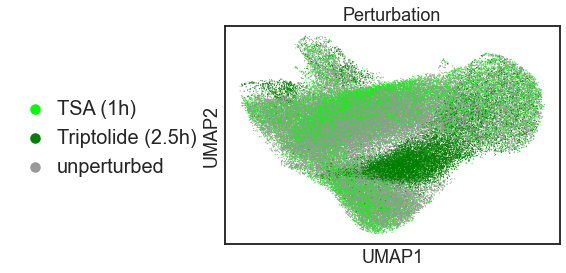

In [80]:
# plot perturbation on subset of data
# ensure that order of points is random
random_indices=np.random.permutation(list(range(adata_sub.shape[0])))
fig, ax = plt.subplots()
sc.pl.umap(adata_sub[random_indices], color='perturbation_plot', size=5, legend_loc='right margin', title='Perturbation', ax=ax, show=False)
# move legend
plt.legend(bbox_to_anchor=(-0.65, 0.7), loc=2, borderaxespad=0., ncol=1, frameon=False, prop={'size': 20}, handletextpad=0.1)
plt.savefig(fig_dir/'umap_VAE_perturbation.pdf', bbox_inches='tight', dpi=300)

/home/icb/hannah.spitzer/miniconda3/envs/campa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


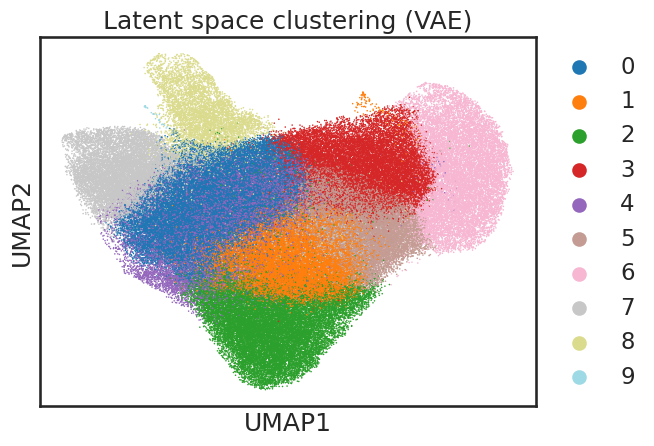

In [26]:
# plot annotated clustering
random_indices=np.random.permutation(list(range(adata.shape[0])))
fig, ax = plt.subplots()
sc.pl.umap(adata[random_indices], color='clustering_res0.5', size=5, legend_loc='right margin', title='Latent space clustering (VAE)', ax=ax, show=False)
plt.savefig(fig_dir/'umap_VAE_clustering_all.png', bbox_inches='tight', dpi=300)

#### example cells

In [21]:
cluster_data_dir = os.path.join('VAE_all/VAE', 'aggregated/sub-0.001')
num_objs = 5
cluster_name = 'clustering_res0.5'

example_cells = {}
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
cl.set_cluster_name(cluster_name) 
for name, mpp_data in example_mpp_data['VAE'].items():
     # choose num_objs cells
     rng = np.random.default_rng(seed=40)
     obj_ids = rng.choice(mpp_data.unique_obj_ids, num_objs, replace=False)
     sub_mpp_data = cl.project_clustering(mpp_data.subset(obj_ids=obj_ids, copy=True))
     example_cells[name] = sub_mpp_data.get_object_imgs(data=cluster_name, annotation_kwargs={'color':True, 'annotation': cl.cluster_annotation}, img_size=160)



INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent', 'umap'].
INFO:MPPData:Loaded data from VAE_all/VAE/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent', 'umap'].
INFO:Cluster:cannot create annotation without clustering in cluster_mpp
INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent', 'clustering_res0.5', 'umap'].
INFO:MPPData:Loaded data from VAE_all/VAE/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent', 'clustering_res0.5', 'umap'].
INFO:MPPData:Before subsetting: 506 objects
INFO:MPPData:Subsetting to 5 objects


Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/VAE/aggregated/sub-0.001/clustering_res0.5.npy


INFO:MPPData:Created new: MPPData for NascentRNA (52084 mpps with shape (1, 1, 35) from 5 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent'].
INFO:Cluster:Projecting clustering to 52084 samples
INFO:Cluster:processing chunk 0
INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to 5 objects
INFO:MPPData:Created new: MPPData for NascentRNA (51592 mpps with shape (1, 1, 35) from 5 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent'].
INFO:Cluster:Projecting clustering to 51592 samples
INFO:Cluster:processing chunk 0
INFO:MPPData:Before subsetting: 617 objects
INFO:MPPData:Subsetting to 5 objects
INFO:MPPData:Created new: MPPData for NascentRNA (64506 mpps with shape (1, 1, 35) from 5 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'latent'].
INFO:Cluster:Projecting clustering to 64506 samples
INFO:Cluster:processing chunk 0


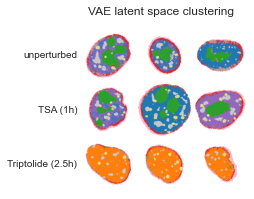

In [22]:
perts = ['unperturbed', 'TSA (1h)', 'Triptolide (2.5h)']
sns.set_context('talk')
with sns.axes_style('white'):
    fig, axes = plt.subplots(3,3, figsize=(3,3))
    for j, col in enumerate(axes.T):
        for i, ax in enumerate(col):
            ax.imshow(example_cells[perts[i]][j])
            ax.set_yticks([])
            ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(perts[i], rotation=0, ha='right', va='center', fontsize=10)
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle('VAE latent space clustering', size=12)
    sns.despine(left=True, bottom=True)
plt.savefig(fig_dir/'example_cells_VAE.pdf', dpi=300, bbox_inches='tight')

/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_51534/1032697199.py:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


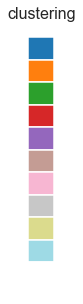

In [23]:
# build cluster colorbar
fig, ax = plt.subplots(1,1, figsize=(0.5,5))
ax.barh(range(11), height=1, width=1, color=cl.cluster_annotation['clustering_res0.5_colors'])
ax.set_title('clustering', fontdict={'fontsize': 16})
ax.invert_yaxis()
ax.axis('off')
plt.tight_layout()
plt.savefig(fig_dir/'cluster_colorbar_VAE.pdf', dpi=100, bbox_inches='tight')

### MPPleiden

In [81]:
adata = adatas['MPPleiden']
adata_sub = adatas_sub['MPPleiden']
# add colors
adata_sub.uns['perturbation_plot_colors'] = [perturbation_plot_colors[p] for p in adata_sub.obs['perturbation_plot'].cat.categories]

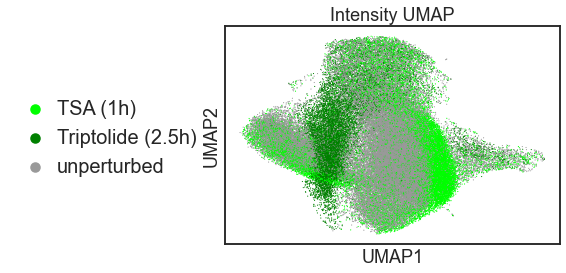

: 

In [82]:
# plot perturbation
# ensure that order of points is random
random_indices=np.random.permutation(list(range(adata_sub.shape[0])))
fig, ax = plt.subplots()
sc.pl.umap(adata_sub[random_indices], color='perturbation_plot', size=5, legend_loc='right margin', title='Intensity UMAP', ax=ax, show=False)
# move legend
plt.legend(bbox_to_anchor=(-0.65, 0.7), loc=2, borderaxespad=0., ncol=1, frameon=False, prop={'size': 20}, handletextpad=0.1)
plt.savefig(fig_dir/'umap_MPPleiden_perturbation.pdf', bbox_inches='tight', dpi=300)

/home/icb/hannah.spitzer/miniconda3/envs/campa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


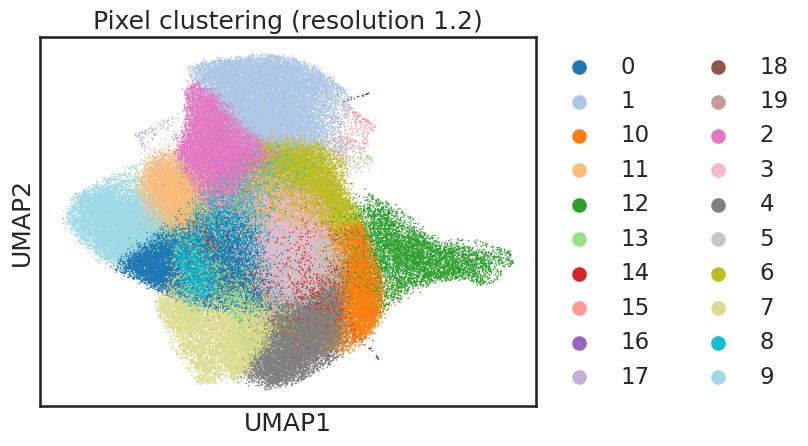

In [32]:
# plot annotated clustering
random_indices=np.random.permutation(list(range(adata.shape[0])))
fig, ax = plt.subplots()
sc.pl.umap(adata[reordered_indices], color='clustering_res1.2', size=5, legend_loc='right margin', title='Pixel clustering (resolution 1.2)', ax=ax, show=False)
plt.savefig(fig_dir/'umap_MPPleiden_clustering_all.png', bbox_inches='tight', dpi=300)

#### example cells

In [26]:
cluster_data_dir = os.path.join('VAE_all/MPPleiden', 'aggregated/sub-0.001')
num_objs = 5
cluster_name = 'clustering_res1.2'

example_cells = {}
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
cl.set_cluster_name(cluster_name)
# NOTE: ensure that clustering is U21 to have correct background color
cl.cluster_mpp._data[cluster_name] = cl.cluster_mpp._data[cluster_name].astype('<U21')
for name, mpp_data in example_mpp_data['MPPleiden'].items():
     # choose num_objs cells
     rng = np.random.default_rng(seed=40)
     obj_ids = rng.choice(mpp_data.unique_obj_ids, num_objs, replace=False)
     sub_mpp_data = cl.project_clustering(mpp_data.subset(obj_ids=obj_ids, copy=True))
     example_cells[name] = sub_mpp_data.get_object_imgs(data=cluster_name, annotation_kwargs={'color':True, 'annotation': cl.cluster_annotation}, img_size=160)


INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'umap'].
INFO:MPPData:Loaded data from VAE_all/MPPleiden/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'umap'].
INFO:Cluster:cannot create annotation without clustering in cluster_mpp
INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'clustering_res1.2', 'umap'].
INFO:MPPData:Loaded data from VAE_all/MPPleiden/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp', 'clustering_res1.2', 'umap'].
INFO:MPPData:Before subsetting: 506 objects
INFO:MPPData:Subsetting to 5 objects


Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/MPPleiden/aggregated/sub-0.001/clustering_res1.2.npy


INFO:MPPData:Created new: MPPData for NascentRNA (52084 mpps with shape (1, 1, 34) from 5 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp'].
INFO:Cluster:Projecting clustering to 52084 samples
INFO:Cluster:processing chunk 0
INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to 5 objects
INFO:MPPData:Created new: MPPData for NascentRNA (51592 mpps with shape (1, 1, 34) from 5 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp'].
INFO:Cluster:Projecting clustering to 51592 samples
INFO:Cluster:processing chunk 0
INFO:MPPData:Before subsetting: 617 objects
INFO:MPPData:Subsetting to 5 objects
INFO:MPPData:Created new: MPPData for NascentRNA (64506 mpps with shape (1, 1, 34) from 5 objects). Data keys: ['y', 'x', 'obj_ids', 'mpp'].
INFO:Cluster:Projecting clustering to 64506 samples
INFO:Cluster:processing chunk 0


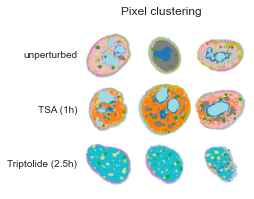

In [27]:
perts = ['unperturbed', 'TSA (1h)', 'Triptolide (2.5h)']
sns.set_context('talk')
with sns.axes_style('white'):
    fig, axes = plt.subplots(3,3, figsize=(3,3))
    for j, col in enumerate(axes.T):
        for i, ax in enumerate(col):
            ax.imshow(example_cells[perts[i]][j])
            ax.set_yticks([])
            ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(perts[i], rotation=0, ha='right', va='center', fontsize=10)
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle('Pixel clustering', size=12)
    sns.despine(left=True, bottom=True)
plt.savefig(fig_dir/'example_cells_MPPleiden.pdf', dpi=300, bbox_inches='tight')

/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_51534/1638251045.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


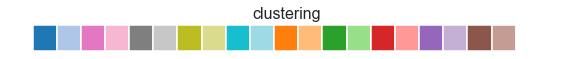

In [28]:
# build cluster colorbar
fig, ax = plt.subplots(1,1, figsize=(10,0.5))
ax.bar(range(21), height=1, width=1, color=cl.cluster_annotation['clustering_res1.2_colors'])
ax.set_title('clustering', fontdict={'fontsize': 16})
ax.invert_yaxis()
ax.axis('off')
plt.tight_layout()
plt.savefig(fig_dir/'cluster_colorbar_MPPleiden.pdf', dpi=100, bbox_inches='tight')

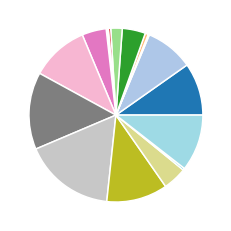

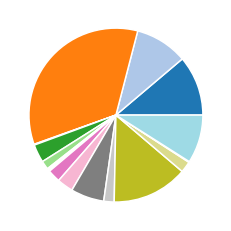

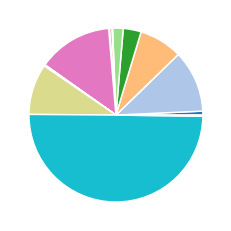

In [29]:
# pie chart
# TODO repeat for cVAE
adata = adatas['MPPleiden']
cluster_name = 'clustering_res1.2'

cluster_size = {}
for pert, grp in adata.obs.groupby('perturbation_plot'):
    cluster_size[pert] = grp.groupby(cluster_name)['mapobject_id'].count()
df = pd.concat(cluster_size, axis=1)
df = df / df.sum(axis=0)
df = pd.merge(df, cl.cluster_annotation, how='left', left_index=True, right_on=cluster_name)

for pert in ['unperturbed', 'TSA (1h)', 'Triptolide (2.5h)']:
    plt.figure()
    _ = plt.pie(df[pert], colors = df['clustering_res1.2_colors'])
    plt.savefig(fig_dir/f'cluster_pie_chart_MPPleiden_{pert}.pdf', dpi=300, bbox_inches='tight')

## Cluster size variation per perturbation
using all perturbations

In [30]:
coeff_variation = {'CondVAE':{}, 'MPPleiden':{}, 'VAE':{}}

sns.set_style('white')
sns.set_context('poster', rc = {'patch.linewidth': 0.0})

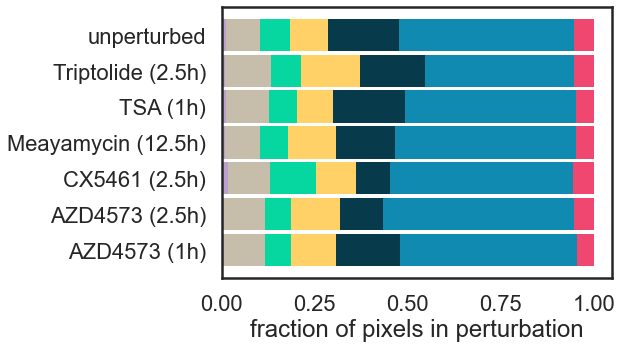

In [31]:
# calculate
adata = adatas['CondVAE']
cluster_name = 'annotation'

cluster_size = {}
for pert, grp in adata.obs.groupby('perturbation_plot'):
    cluster_size[pert] = grp.groupby(cluster_name)['mapobject_id'].count()
df = pd.concat(cluster_size, axis=1)
df = df / df.sum(axis=0)

coeff_variation['CondVAE'][cluster_name] = df.std(axis=1) / df.mean(axis=1)

# plot
cats = adata.obs[cluster_name].cat.categories
fig, ax = plt.subplots(figsize=(7,5))
bottom = np.array([0 for _ in df.columns]).astype('float')
for i in range(len(cats)):
    if i > 0:
        bottom += np.array(df.loc[cats[i-1]])
    ax.barh(list(df.columns), list(df.loc[cats[i]]), 0.9, label=cats[i], left=bottom, 
        color=adata.uns[cluster_name+'_colors'][i])
ax.set_xlabel('fraction of pixels in perturbation')
plt.savefig(fig_dir/f'cluster_size_condVAE_{cluster_name}.pdf', bbox_inches='tight')

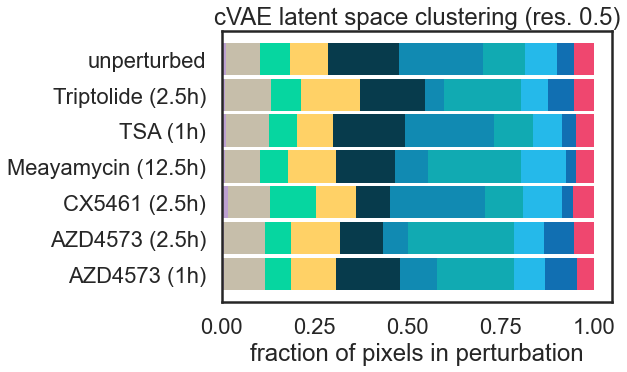

In [35]:
# calculate
adata = adatas['CondVAE']
cluster_name = 'annotation_fine'

cluster_size = {}
for pert, grp in adata.obs.groupby('perturbation_plot'):
    cluster_size[pert] = grp.groupby(cluster_name)['mapobject_id'].count()
df = pd.concat(cluster_size, axis=1)
df = df / df.sum(axis=0)

coeff_variation['CondVAE'][cluster_name] = df.std(axis=1) / df.mean(axis=1)

# plot
cats = adata.obs[cluster_name].cat.categories
fig, ax = plt.subplots(figsize=(7,5))
bottom = np.array([0 for _ in df.columns]).astype('float')
for i in range(len(cats)):
    if i > 0:
        bottom += np.array(df.loc[cats[i-1]])
    ax.barh(list(df.columns), list(df.loc[cats[i]]), 0.9, label=cats[i], left=bottom, 
        color=adata.uns[cluster_name+'_colors'][i])
ax.set_xlabel('fraction of pixels in perturbation')
ax.set_title('cVAE latent space clustering (res. 0.5)')
plt.savefig(suppl_dir/f'cluster_size_condVAE_{cluster_name}.pdf', bbox_inches='tight')

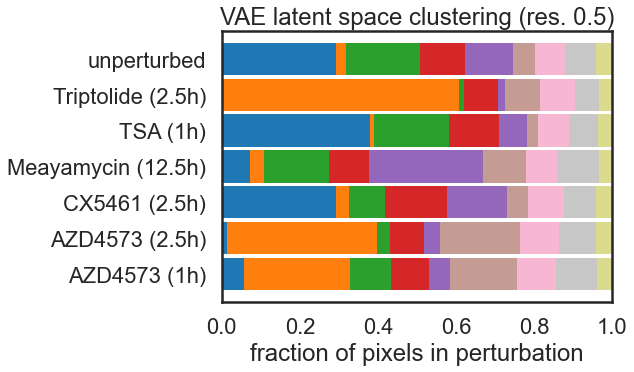

In [38]:
# calculate
adata = adatas['VAE']
cluster_name = 'clustering_res0.5'

cluster_size = {}
for pert, grp in adata.obs.groupby('perturbation_plot'):
    cluster_size[pert] = grp.groupby(cluster_name)['mapobject_id'].count()
df = pd.concat(cluster_size, axis=1)
df = df / df.sum(axis=0)

coeff_variation['VAE'][cluster_name] = df.std(axis=1) / df.mean(axis=1)

# plot
cats = adata.obs[cluster_name].cat.categories
fig, ax = plt.subplots(figsize=(7,5))
bottom = np.array([0 for _ in df.columns]).astype('float')
for i in range(len(cats)):
    if i > 0:
        bottom += np.array(df.loc[cats[i-1]])
    ax.barh(list(df.columns), list(df.loc[cats[i]]), 0.9, label=cats[i], left=bottom, 
        color=adata.uns[cluster_name+'_colors'][i])
ax.set_xlabel('fraction of pixels in perturbation')
ax.set_title('VAE latent space clustering (res. 0.5)')
plt.savefig(suppl_dir/f'cluster_size_VAE_{cluster_name}.pdf', bbox_inches='tight')

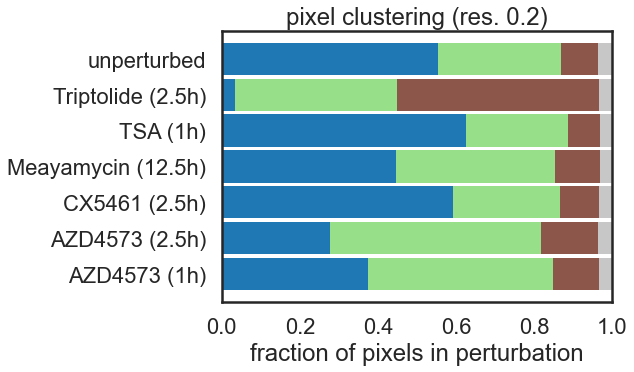

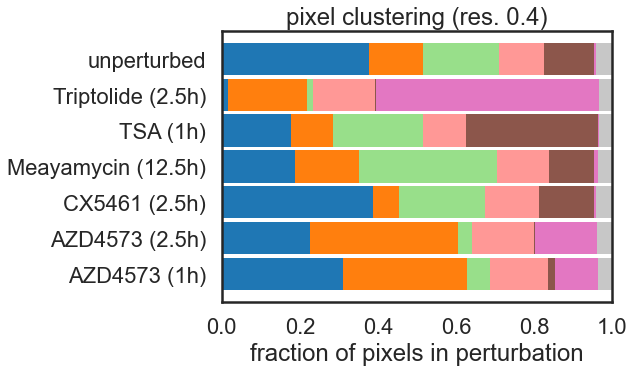

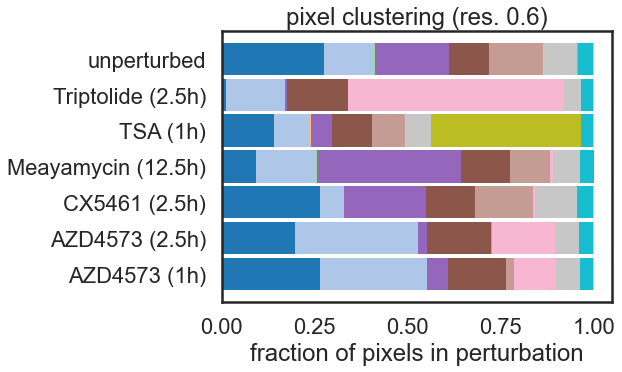

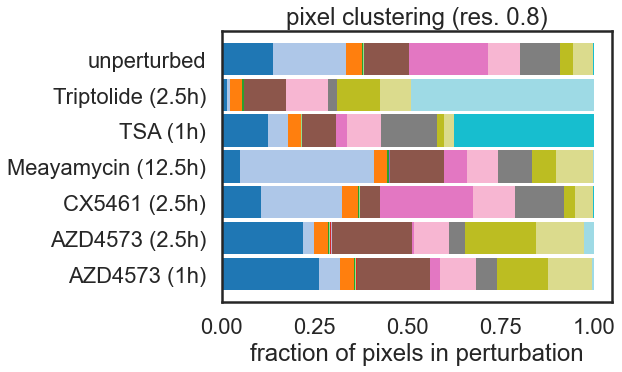

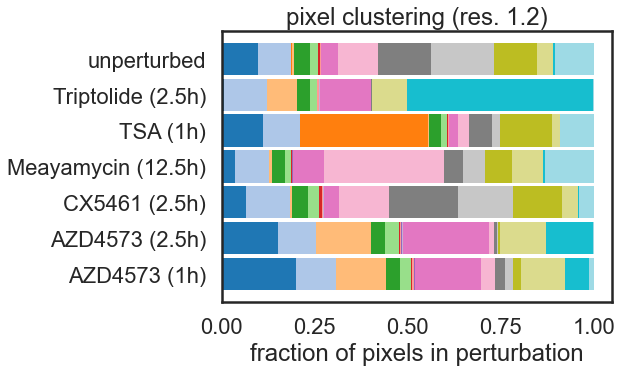

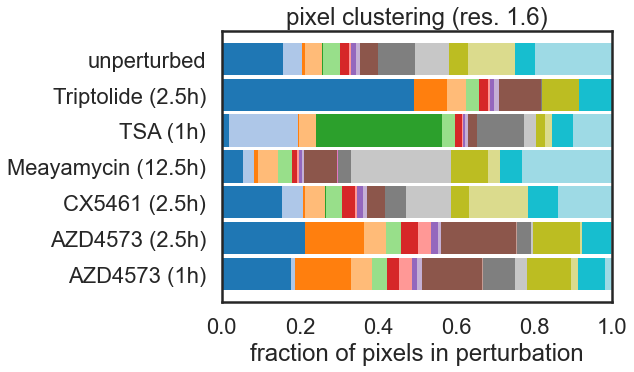

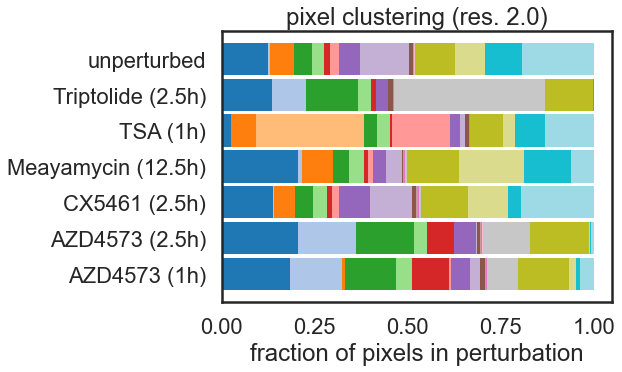

In [37]:
# calculate
adata = adatas['MPPleiden']
for res in [0.2, 0.4, 0.6, 0.8, 1.2, 1.6, 2.0]:
    cluster_name = f'clustering_res{res:.1f}'

    cluster_size = {}
    for pert, grp in adata.obs.groupby('perturbation_plot'):
        cluster_size[pert] = grp.groupby(cluster_name)['mapobject_id'].count()
    df = pd.concat(cluster_size, axis=1)
    df = df / df.sum(axis=0)

    coeff_variation['MPPleiden'][cluster_name] = df.std(axis=1) / df.mean(axis=1)

    # plot
    cats = adata.obs[cluster_name].cat.categories
    fig, ax = plt.subplots(figsize=(7,5))
    bottom = np.array([0 for _ in df.columns]).astype('float')
    for i in range(len(cats)):
        if i > 0:
            bottom += np.array(df.loc[cats[i-1]])
        ax.barh(list(df.columns), list(df.loc[cats[i]]), 0.9, label=cats[i], left=bottom, 
            color=adata.uns[cluster_name+'_colors'][i])
    ax.set_xlabel('fraction of pixels in perturbation')
    ax.set_title(f'pixel clustering (res. {res:.1f})')
    plt.savefig(suppl_dir/f'cluster_size_MPPleiden_{cluster_name}.pdf', bbox_inches='tight')

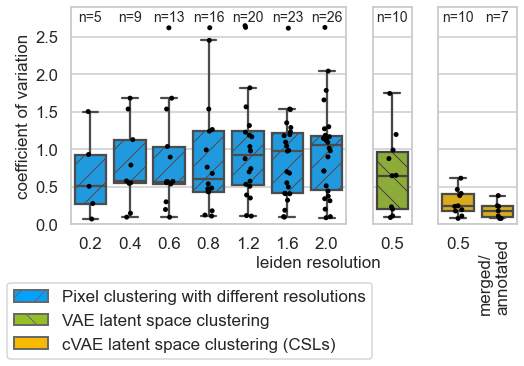

In [40]:
# updated plot for revision - including VAE
sns.set_style('whitegrid')
sns.set_context('talk', rc = {'font.family': 'Arial'})
fs_labels = 17
fs_n = 14
fs_ax = 17

df = pd.concat(coeff_variation['MPPleiden']).reset_index()
fig, axes = plt.subplots(1,3, figsize=(8,4), sharey=True, gridspec_kw={'width_ratios': [7, 1, 2]})
p = sns.boxplot(data=df, x='level_0', y=0, color=blue, ax=axes[0], showfliers = False)
sns.stripplot(data=df, x='level_0', y=0, color='black', ax=axes[0])
p.set_xlabel('')
#p.set_xlabel('Pixel clustering with\ndifferent leiden parameters',  fontsize=fs_labels)
p.set_ylabel('coefficient of variation', fontsize=fs_labels)
axes[0].set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.2, 1.6, 2.0], fontdict={'fontsize': fs_ax})
for patch in axes[0].patches:
    patch.set_hatch('/')
# add cluster number
num_clusters = [len(adatas['MPPleiden'].obs[f'clustering_res{res:.1f}'].cat.categories) for res in [0.2, 0.4, 0.6, 0.8, 1.2, 1.6, 2.0]]
for i,n in enumerate(num_clusters):
    axes[0].annotate(f'n={n}', (i,2.7), ha='center', fontsize=fs_n)

df = coeff_variation['VAE']['clustering_res0.5'].reset_index()
df['level_0'] = 1
p = sns.boxplot(data=df, x='level_0', y=0, color=green, ax=axes[1], showfliers = False)
sns.stripplot(data=df, x='level_0', y=0, color='black', ax=axes[1])
axes[1].set_xticklabels([0.5], fontdict={'fontsize': fs_ax})
p.set(xlabel='', ylabel='')
for patch in axes[1].patches:
    patch.set_hatch('\\')
# add cluster number
num_clusters = len(adatas['VAE'].obs[f'clustering_res0.5'].cat.categories)
axes[1].annotate(f'n={num_clusters}', (0,2.7), ha='center', fontsize=fs_n)
axes[0].annotate(f'leiden resolution', (0.9,-0.2), ha='center', fontsize=fs_labels, xycoords='axes fraction')

df = pd.concat({'CSL': coeff_variation['CondVAE']['annotation_fine'], 'annotated CSL': coeff_variation['CondVAE']['annotation']}).reset_index()
p = sns.boxplot(data=df, x='level_0', y=0, color=yellow, ax=axes[2], showfliers = False)
sns.stripplot(data=df, x='level_0', y=0, color='black', ax=axes[2])
axes[2].set_xticklabels([0.5, ""], fontdict={'fontsize': fs_ax})
axes[2].annotate("merged/\nannotated", (0.5,-0.4), fontsize=fs_ax, rotation=90, xycoords='axes fraction')
p.set(xlabel='', ylabel='')
# add cluster number
num_clusters = [len(adatas['CondVAE'].obs[f'annotation_fine'].cat.categories), len(adatas['CondVAE'].obs[f'annotation'].cat.categories)]
for i,n in enumerate(num_clusters):
    axes[2].annotate(f'n={n}', (i,2.7), ha='center', fontsize=fs_n)
#axes[2].annotate(f'cVAE latent space\nclustering (CSLs)', (1,-0.33), ha='center', fontsize=fs_labels, xycoords='axes fraction')

plt.ylim(0,2.9)

# create legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
custom_lines = [Patch(facecolor=blue, edgecolor="dimgrey", lw=2, hatch="/"),
                Patch(facecolor=green, edgecolor="dimgrey", lw=2, hatch="\\"),
                Patch(facecolor=yellow, edgecolor="dimgrey", lw=2)]


fig.legend(custom_lines, ['Pixel clustering with different resolutions', 
                          'VAE latent space clustering', 'cVAE latent space clustering (CSLs)'], 
           prop={'size': fs_labels}, loc='upper left', bbox_to_anchor=(0,-0.05,3,0))

plt.savefig(fig_dir/'coeff_variation_clustering_v2.pdf', bbox_inches='tight', dpi=300)

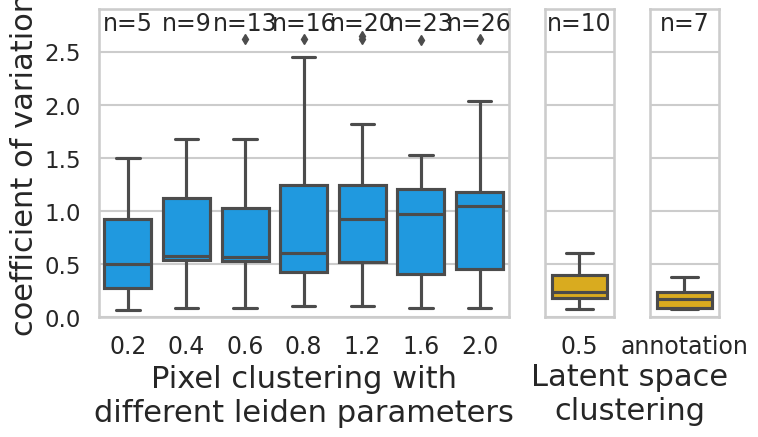

In [20]:
# plot for initial submission
sns.set_style('whitegrid')
sns.set_context('talk', rc = {'font.family': 'Arial'})
fs_labels = 22
fs_n = 17
fs_ax = 17

df = pd.concat(coeff_variation['MPPleiden']).reset_index()
fig, axes = plt.subplots(1,3, figsize=(8,4), sharey=True, gridspec_kw={'width_ratios': [6, 1, 1]})
p = sns.boxplot(data=df, x='level_0', y=0, color=blue, ax=axes[0])
p.set_xlabel('Pixel clustering with\ndifferent leiden parameters',  fontsize=fs_labels)
p.set_ylabel('coefficient of variation', fontsize=fs_labels)
axes[0].set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.2, 1.6, 2.0], fontdict={'fontsize': fs_ax})
# add cluster number
num_clusters = [len(adatas['MPPleiden'].obs[f'clustering_res{res:.1f}'].cat.categories) for res in [0.2, 0.4, 0.6, 0.8, 1.2, 1.6, 2.0]]
for i,n in enumerate(num_clusters):
    axes[0].annotate(f'n={n}', (i,2.7), ha='center', fontsize=fs_n)

df = coeff_variation['CondVAE']['annotation_fine'].reset_index()
df['level_0'] = 1
p = sns.boxplot(data=df, x='level_0', y=0, color=yellow, ax=axes[1])
axes[1].set_xticklabels([0.5], fontdict={'fontsize': fs_ax})
p.set(xlabel='', ylabel='')
# add cluster number
num_clusters = len(adatas['CondVAE'].obs[f'annotation_fine'].cat.categories)
axes[1].annotate(f'n={num_clusters}', (0,2.7), ha='center', fontsize=fs_n)

df = coeff_variation['CondVAE']['annotation'].reset_index()
df['level_0'] = 1
p = sns.boxplot(data=df, x='level_0', y=0, color=yellow, ax=axes[2])
axes[2].set_xticklabels(['annotation'], fontdict={'fontsize': fs_ax})
p.set(xlabel='', ylabel='')
# add cluster number
num_clusters = len(adatas['CondVAE'].obs[f'annotation'].cat.categories)
axes[2].annotate(f'n={num_clusters}', (0,2.7), ha='center', fontsize=fs_n)
axes[2].annotate(f'Latent space\nclustering', (-0.3,-0.33), ha='center', fontsize=fs_labels, xycoords='axes fraction')

plt.ylim(0,2.9)
plt.savefig(fig_dir/'coeff_variation_clustering.png', bbox_inches='tight', dpi=300)

In [59]:
# print mean coefficient of variation
print('MPPleiden clustering')
for res in [0.2, 0.4, 0.6, 0.8, 1.2, 1.6, 2.0]:
    print('\tresolution {}: {:.2f}, min {:.2f}, max {:.2f}'.format( res,
        np.median(coeff_variation['MPPleiden'][f'clustering_res{res:.1f}']),
        np.min(coeff_variation['MPPleiden'][f'clustering_res{res:.1f}']),
        np.max(coeff_variation['MPPleiden'][f'clustering_res{res:.1f}'])))
print('VAE clustering: {:.2f}, min {:.2f}, max {:.2f}'.format(np.median(coeff_variation['VAE']['clustering_res0.5']),
                                                                 np.min(coeff_variation['VAE']['clustering_res0.5']),
                                                                 np.max(coeff_variation['VAE']['clustering_res0.5'])))
print('CondVAE clustering: {:.2f}, min {:.2f}, max {:.2f}'.format(np.median(coeff_variation['CondVAE']['annotation_fine']),
                                                                 np.min(coeff_variation['CondVAE']['annotation_fine']),
                                                                 np.max(coeff_variation['CondVAE']['annotation_fine'])))
print('CondVAE annotation: {:.2f}, min {:.2f}, max {:.2f}'.format(np.median(coeff_variation['CondVAE']['annotation']),
                                                                 np.min(coeff_variation['CondVAE']['annotation']),
                                                                 np.max(coeff_variation['CondVAE']['annotation'])))

MPPleiden clustering
	resolution 0.2: 0.50, min 0.07, max 1.50
	resolution 0.4: 0.58, min 0.09, max 1.68
	resolution 0.6: 0.57, min 0.09, max 2.62
	resolution 0.8: 0.61, min 0.11, max 2.62
	resolution 1.2: 0.92, min 0.11, max 2.65
	resolution 1.6: 0.97, min 0.09, max 2.61
	resolution 2.0: 1.05, min 0.08, max 2.62
VAE clustering: 0.65, min 0.09, max 1.74
CondVAE clustering: 0.24, min 0.08, max 0.61
CondVAE annotation: 0.17, min 0.08, max 0.38


## Linear classifier for predicting perturbation from latent space (on val data)

### calculate scores

In [76]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score

def get_prediction_scores(X, y, measure='acc', n_val=10000, class_weights=None):
    scaled_X = preprocessing.StandardScaler().fit_transform(X)
    np.random.seed(0)
    scores = []
    # 10 times with different score
    for i in range(10):
        mask = np.full(len(y), False)
        mask[:n_val] = True
        np.random.shuffle(mask)
        clf = LogisticRegression().fit(scaled_X[~mask] , y[~mask])
        #print(len(scaled_X[mask]))
        ypred = clf.predict(scaled_X[mask])
        if measure == 'acc':
            weights = None
            if class_weights is not None:
                weights = class_weights[y[mask].astype(int)]
            score = accuracy_score(y[mask], ypred, sample_weight=weights)
        elif measure == 'balanced_acc':
            score = balanced_accuracy_score(y[mask], ypred)
        scores.append(score)
    return scores

In [77]:
exp_name = 'VAE_all/CondVAE_pert-CC'
val_data = MPPData.from_data_dir(data_dir=exp_name+'/results_epoch025/val', base_dir=campa_config.EXPERIMENT_DIR, keys=['x','y','obj_ids','latent'], data_config='NascentRNA')
adata_val = val_data.get_adata(obsm={'X_latent':'latent'})
add_perturbation_plot(adata_val)

exp_name = 'VAE_all/VAE'
val_data = MPPData.from_data_dir(data_dir=exp_name+'/results_epoch025/val', base_dir=campa_config.EXPERIMENT_DIR, keys=['x','y','obj_ids','latent'], data_config='NascentRNA')
adata_val_vae = val_data.get_adata(obsm={'X_latent':'latent'})
add_perturbation_plot(adata_val_vae)

INFO:MPPData:Created new: MPPData for NascentRNA (76432 mpps with shape (3, 3, 34) from 1181 objects). Data keys: ['obj_ids', 'y', 'x', 'mpp', 'conditions', 'labels'].
INFO:MPPData:Loaded data from datasets/184A1_all_frac0005_neigh3_cond_pert-CC/val.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (76432 mpps with shape (1, 1, 34) from 1181 objects). Data keys: ['obj_ids', 'y', 'x', 'latent', 'mpp'].
INFO:MPPData:Before subsetting: 1181 objects
INFO:MPPData:Subsetting to 1181 objects
INFO:MPPData:Updated data to keys ['obj_ids', 'y', 'x', 'mpp', 'conditions', 'labels', 'latent']
INFO:MPPData:Loaded data from VAE_all/CondVAE_pert-CC/results_epoch025/val, with base data from datasets/184A1_all_frac0005_neigh3_cond_pert-CC/val
INFO:MPPData:Created new: MPPData for NascentRNA (76432 mpps with shape (3, 3, 34) from 1181 objects). Data keys: ['obj_ids', 'y', 'x', 'mpp', 'conditions', 'labels'].
INFO:MPPData:Loaded data from datasets/184A1_all_frac0005

In [78]:
scores = {}
# classification from latent
scores_latent = {}
for pert in ['AZD4573 (1h)', 'AZD4573 (2.5h)', 'CX5461 (2.5h)', 'Meayamycin (12.5h)', 'TSA (1h)', 'Triptolide (2.5h)']:
    # prediction scores for distinguishing perturbations
    mask = np.in1d(adata_val.obs['perturbation_plot'], ['unperturbed', pert])
    y = adata_val[mask].obs['perturbation_plot'] == pert
    X = adata_val[mask].obsm['X_latent']
    X_pca = PCA(n_components=10).fit_transform(X)
    scores_latent[pert] = get_prediction_scores(X_pca, y, n_val=int(len(y)*0.1), measure='balanced_acc')
scores['cVAE latent space'] = scores_latent

# classification from MPP
scores_mpp = {}
for pert in ['AZD4573 (1h)', 'AZD4573 (2.5h)', 'CX5461 (2.5h)', 'Meayamycin (12.5h)', 'TSA (1h)', 'Triptolide (2.5h)']:
    # prediction scores for distinguishing perturbations
    mask = np.in1d(adata_val.obs['perturbation_plot'], ['unperturbed', pert])
    y = adata_val[mask].obs['perturbation_plot'] == pert
    X = adata_val[mask].X
    X_pca = PCA(n_components=10).fit_transform(X)
    scores_mpp[pert] = get_prediction_scores(X_pca, y, n_val=int(len(y)*0.1), measure='balanced_acc')
scores['pixel profile'] = scores_mpp

# classification from VAE
scores_vae = {}
for pert in ['AZD4573 (1h)', 'AZD4573 (2.5h)', 'CX5461 (2.5h)', 'Meayamycin (12.5h)', 'TSA (1h)', 'Triptolide (2.5h)']:
    # prediction scores for distinguishing perturbations
    mask = np.in1d(adata_val_vae.obs['perturbation_plot'], ['unperturbed', pert])
    y = adata_val_vae[mask].obs['perturbation_plot'] == pert
    X = adata_val_vae[mask].obsm['X_latent']
    X_pca = PCA(n_components=10).fit_transform(X)
    scores_vae[pert] = get_prediction_scores(X_pca, y, n_val=int(len(y)*0.1), measure='balanced_acc')
scores['VAE latent space'] = scores_vae

# save scores
json.dump(scores, open(fig_dir/'acc_linear_classifier.json', 'w'), indent=4)

### plot scores

In [41]:
scores = json.load(open(fig_dir/'acc_linear_classifier.json', 'r'))

In [42]:
df = pd.concat({key: pd.DataFrame(scores[key]).mean(axis=0) for key in scores.keys()}, axis=0)
df.index.set_names(['data type', 'perturbation'], inplace=True)
df = df.reset_index().rename(columns={0:'balanced accuracy'})

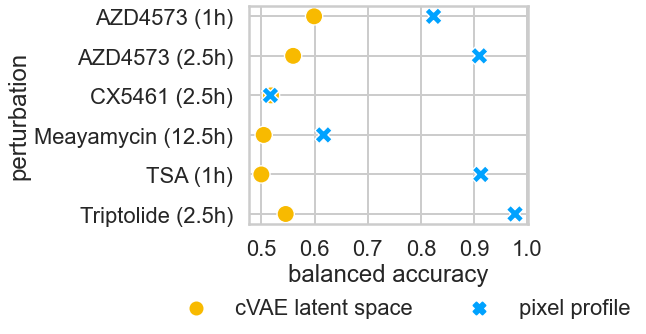

In [43]:
sns.set_style('whitegrid')
sns.set_context('poster')
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.scatterplot(data=df[df['data type'] != 'VAE latent space'], x='balanced accuracy', y='perturbation', hue='data type', style='data type', palette=[yellow, blue], ax=ax, s=300)
plt.xticks([0.5,0.6,0.7,0.8,0.9,1.0])
plt.legend(bbox_to_anchor=(-0.30, -0.30), loc=2, borderaxespad=0., frameon=False, ncol=2)
plt.savefig(fig_dir/'acc_linear_classifier.png', bbox_inches='tight')

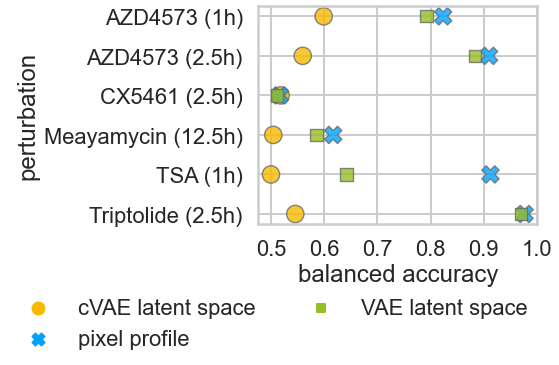

In [44]:
# plot for revision
sns.set_style('whitegrid')
sns.set_context('poster')
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.scatterplot(data=df, x='balanced accuracy', y='perturbation', hue='data type', style='data type', palette=[yellow, blue, green], 
                ax=ax, s=300, alpha=0.8, edgecolor='dimgrey')
plt.xticks([0.5,0.6,0.7,0.8,0.9,1.0])
plt.legend(bbox_to_anchor=(-0.90, -0.30), loc=2, borderaxespad=0., frameon=False, ncol=2)
plt.savefig(fig_dir/'acc_linear_classifier_v2.pdf', bbox_inches='tight')

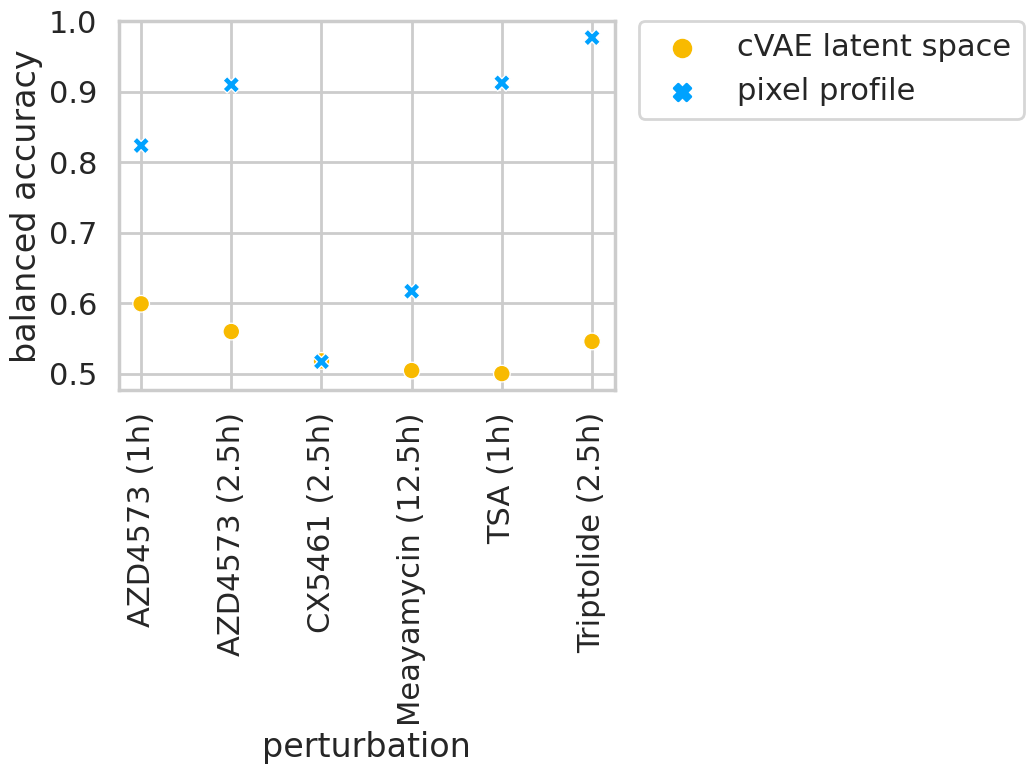

In [70]:
# alternative plot
sns.set_style('whitegrid')
sns.set_context('poster')
sns.scatterplot(data=df[df['data type'] != 'VAE latent space'], x='perturbation', y='balanced accuracy', hue='data type', style='data type', palette=[yellow, blue])
plt.xticks(rotation=90)
plt.yticks([0.5,0.6,0.7,0.8,0.9,1.0])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [ ]:
sns.set_style('whitegrid')
sns.set_context('poster')
fig, ax = plt.subplots(1,1, figsize=(3,3))
sns.scatterplot(data=df, x='balanced accuracy', y='perturbation', hue='data type', style='data type', palette=[yellow, blue], ax=ax, s=200)
plt.xticks([0.5,0.6,0.7,0.8,0.9,1.0])
plt.legend(bbox_to_anchor=(0.00, -0.50), loc=2, borderaxespad=0.)
plt.savefig(fig_dir/'acc_linear_classifier_poster.png', bbox_inches='tight')

In [39]:
# print mean acc for each classifier
df.groupby('data type').median()

/tmp/ipykernel_173243/3107059288.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('data type').median()


,balanced accuracy
data type,
VAE latent space,0.717236
cVAE latent space,0.531820
pixel profile,0.866864


In [40]:
# print mean acc for each classifier
display(df.groupby('data type').min())
display(df.groupby('data type').max())

,perturbation,balanced accuracy
data type,,
VAE latent space,AZD4573 (1h),0.511145
cVAE latent space,AZD4573 (1h),0.499916
pixel profile,AZD4573 (1h),0.516836


,perturbation,balanced accuracy
data type,,
VAE latent space,Triptolide (2.5h),0.969494
cVAE latent space,Triptolide (2.5h),0.599049
pixel profile,Triptolide (2.5h),0.976963
